# 导入必要的库

In [4]:
import pandas as pd
from fbprophet import Prophet

# 导入数据

In [7]:
df = pd.read_csv('example.csv')

In [8]:
df.head()

,ds,y
0,2007/12/10,9.590761
1,2007/12/11,8.519590
2,2007/12/12,8.183677
3,2007/12/13,8.072467
4,2007/12/14,7.893572


# 简易的Prophet模型

In [21]:
#Prophet()可以自己设置参数也可不设置默认
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [10]:
#predict 方法将会对每一行未来 future 日期得到一个预测值（称为 yhat ）。如果你传入了历史数据的日期，它将会提供样本的模型拟合值。预测 forecast 创建的对象应当是一个新的数据框，其中包含一列预测值 yhat ，以及成分的分析和置信区间。
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206367,7.475772,8.950606
3266,2017-01-16,8.531367,7.817544,9.276037
3267,2017-01-17,8.318771,7.561918,8.971491
3268,2017-01-18,8.151386,7.415331,8.873576
3269,2017-01-19,8.163306,7.481960,8.872126


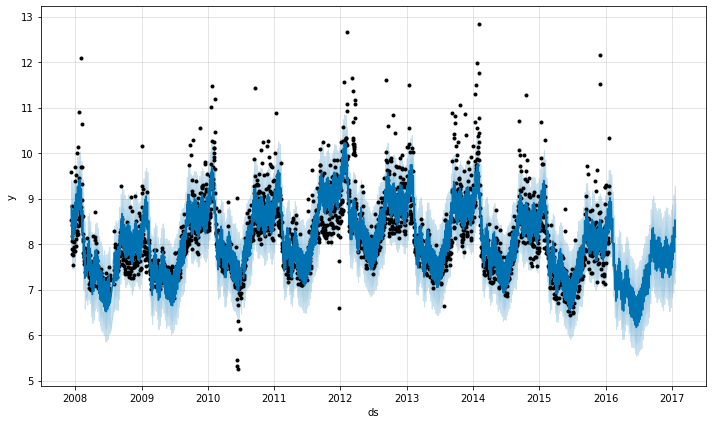

In [12]:
m.plot(forecast);

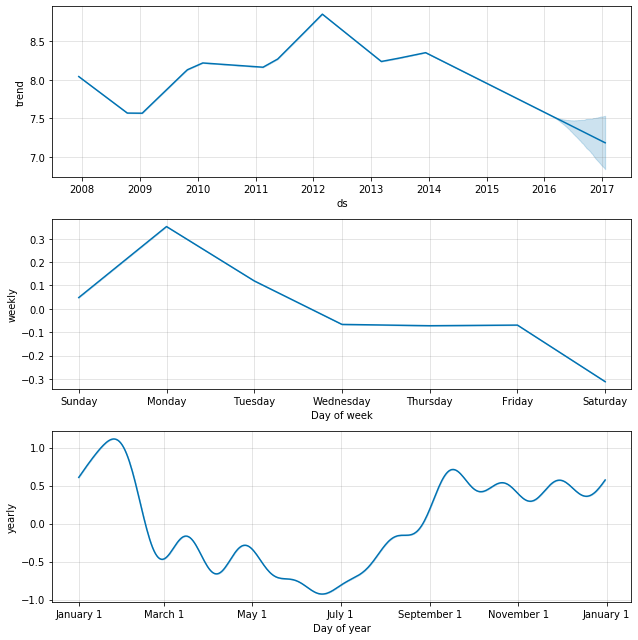

In [13]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
m.plot_components(forecast);

In [15]:
#该模型为加法模型，上图根据该数据列画出
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


# 饱和预测

In [18]:
#设置上限
df['cap'] = 13

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


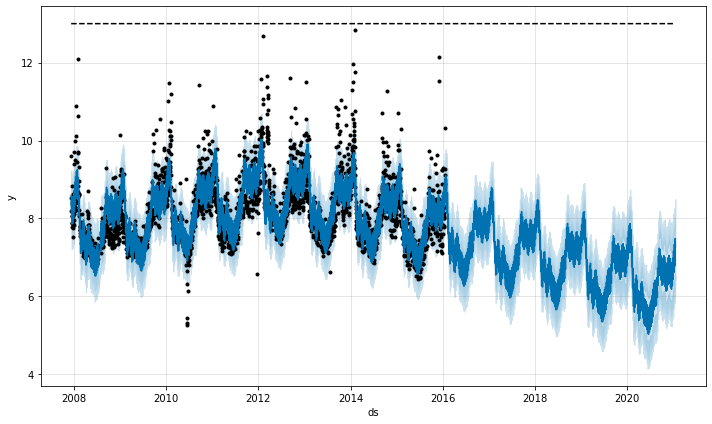

In [22]:
m = Prophet(growth='logistic')
m.fit(df)
future = m.make_future_dataframe(periods=1826)
future['cap'] = 13
fcst = m.predict(future)
fig = m.plot(fcst)

# 转折点或突变点的自动检测

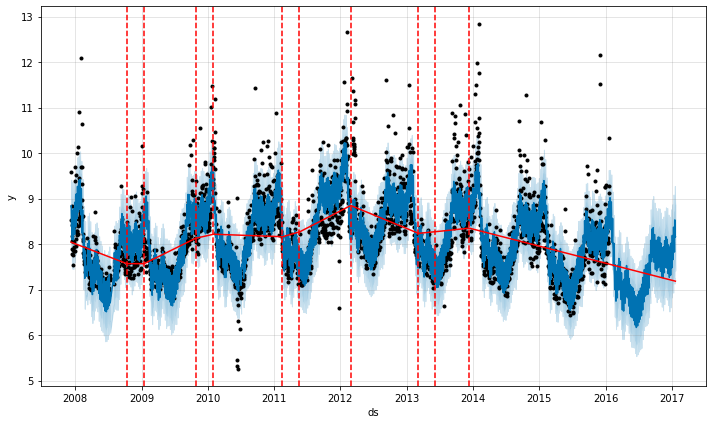

In [20]:
#通过稀疏性先验检测，可以自己设置点数量，也可自动识别显著的
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# 防止转折突变点的欠拟合和过拟合，通过调整稀疏先验程度（增加可能过拟合，减少欠拟合）

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


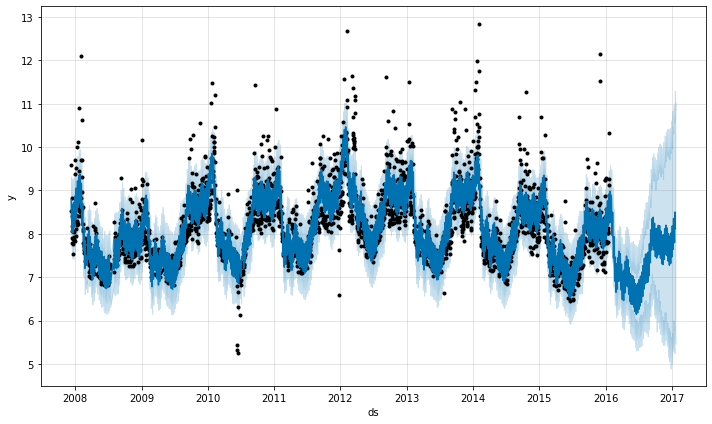

In [23]:
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df)
 
future = m.make_future_dataframe(periods=365)
 
forecast = m.predict(future)
fig = m.plot(forecast)

# 对节假日特殊日期进行建模

In [25]:
# 增加一列特殊日期

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
# lower_window 和 upper_window ，从而将节假日的时间扩展成一个区间，lower_window = -1 , upper_window = 0加入前一天；lower_window = 0 , upper_window = 1加入后一天 

In [26]:

m = Prophet(holidays=holidays)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# 看一下假期的最后10行数据
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.231207,1.200319
2191,2014-02-03,1.911782,1.451262
2532,2015-01-11,1.231207,0.000000
2533,2015-01-12,1.911782,0.000000
2901,2016-01-17,1.231207,0.000000
2902,2016-01-18,1.911782,0.000000
2908,2016-01-24,1.231207,0.000000
2909,2016-01-25,1.911782,0.000000
2922,2016-02-07,1.231207,1.200319
2923,2016-02-08,1.911782,1.451262


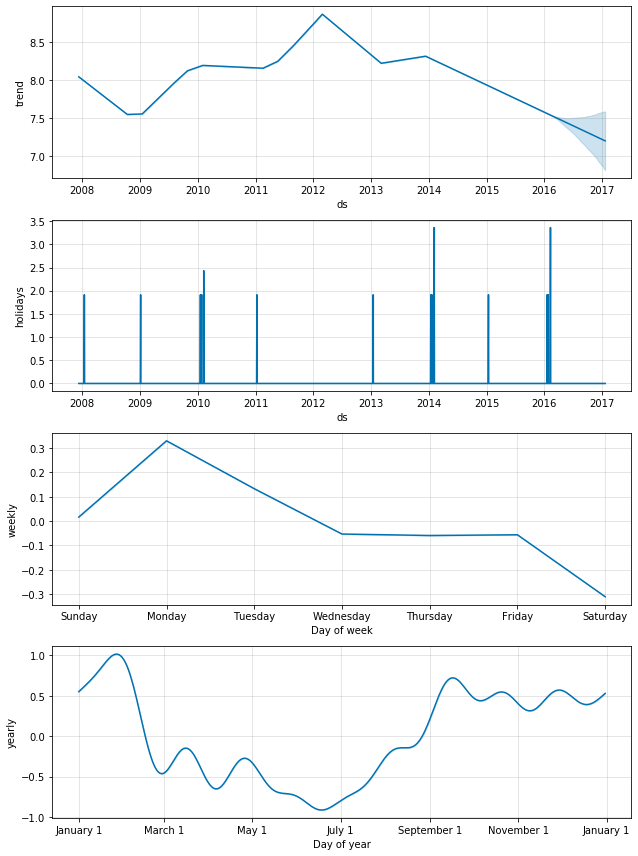

In [28]:
fig = m.plot_components(forecast)

## 提取holiday中superbowl的效应

In [34]:
from fbprophet.plot import plot_forecast_component

In [35]:
m.plot_forecast_component(forecast, 'superbowl')

AttributeError: 'Prophet' object has no attribute 'plot_forecast_component'

# 季节性的傅里叶级数展示

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


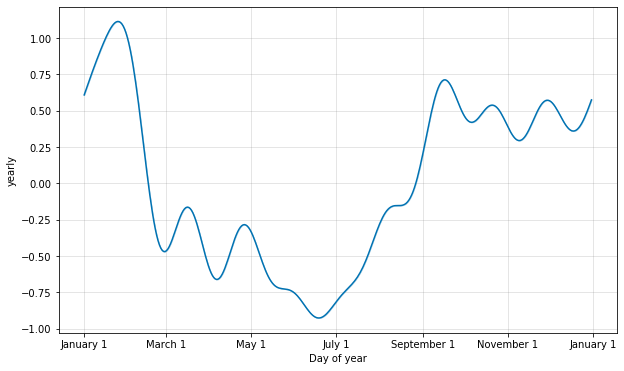

In [36]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)
#默认为N=10

## 季节性需要适应更高频率的变化时，它们可以增加

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


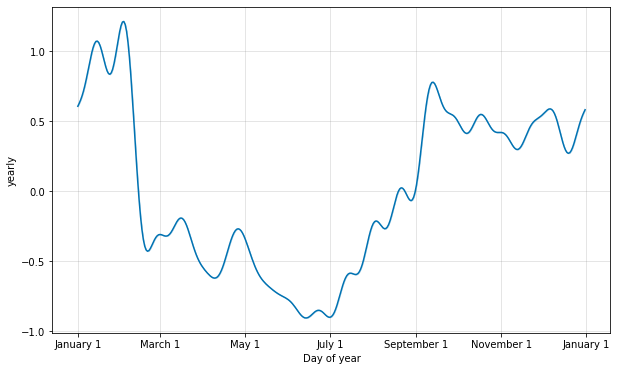

In [37]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

## 自定义季节性因素(用每月的季节性替换每周的季节性)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


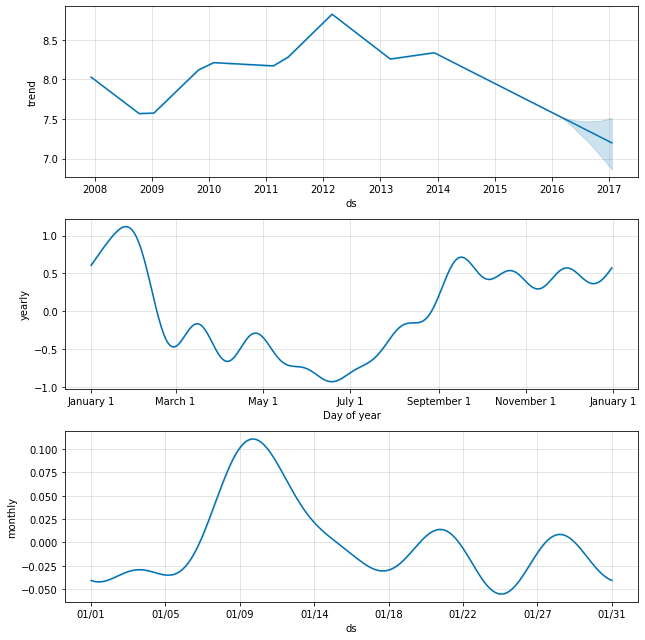

In [38]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)
#period 为模型中的P，fourier_order为傅里叶阶数模型中的N

## 对节假日和季节性设定先验规模(发现节假日效应被过度拟合了)

In [39]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]
#默认为10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.206628,0.967258
2191,2014-02-03,1.854134,0.989893
2532,2015-01-11,1.206628,0.000000
2533,2015-01-12,1.854134,0.000000
2901,2016-01-17,1.206628,0.000000
2902,2016-01-18,1.854134,0.000000
2908,2016-01-24,1.206628,0.000000
2909,2016-01-25,1.854134,0.000000
2922,2016-02-07,1.206628,0.967258
2923,2016-02-08,1.854134,0.989893


# 模拟乘法模型的季节性效应

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


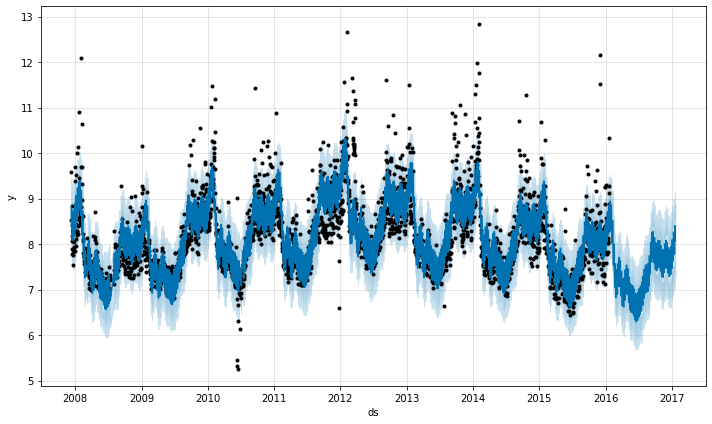

In [40]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

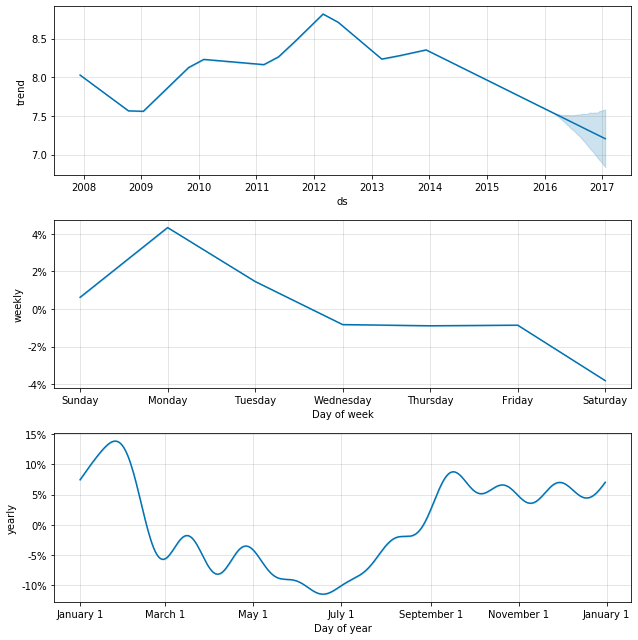

In [41]:
fig = m.plot_components(forecast)

## 加入这时候add了一个季度季节性，会使得加法模型覆盖了乘法模型

In [42]:
#forecast['yhat'] = forecast['trend']  * (1+forecast['multiplicative_terms']) + forecast['additive_terms']。

# 增加预测区间（实际上改变changepoint速率的增加也会增加预测的不确定性）

In [43]:
m = Prophet(interval_width=0.95).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# 季节性的不确定性 通过mcmc方法提取即生成效应分解后置信区间图（会大幅提高运算时间）

In [ ]:
m = Prophet(mcmc_samples=500).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m.plot_components(forecast);

# 异常值处理

In [ ]:
# Prophet 虽能够处理历史数据中的异常值，但仅仅是将它们与趋势的变化拟合在一起，认为未来也会有类似的趋势变化。

In [ ]:
#处理异常值最好的方法是移除它们，而 Prophet 是能够处理缺失数据的。如果在历史数据中某行的值为空（ NA ），但是在待预测日期数据框 future 中仍保留这个日期，那么 Prophet 依旧可以给出该行的预测值。

# 处理非日数据

In [ ]:
future = m.make_future_dataframe(periods=120, freq='M')
#将数据输入为月数据，H为小时数据

In [ ]:
#如果存在有规则频率的数据，不能用freq=，因为季节性的估计效果很差，在为其余时间都是不受约束的
#解决方案是只对有历史数据的时间窗进行预测。这里，这意味着限制未来dataframe的时间

# 预测结果

## 交叉验证

In [ ]:
#initial代表了一开始的时间是多少，period代表每隔多长时间设置一个cutoff，horizon代表每次从cutoff往后预测多少天
#默认情况下，初始训练期设置为horizon的三倍，每半个horizon就有一个截断。
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head(）

## 计算MSE等指标

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

## 指标可视化

In [ ]:
#点表示df_cv中每个预测的绝对误差百分比。蓝线显示的是MAPE，均值被取到滚动窗口的圆点
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')